# Steps involved in making recommendation system:
* Importing neccessary libraries
* Data collection
* Data importing
* Data cleaning and preprocessing
* Data analysis and visualization
* Machine learning model implementation
    1. Content-based filtering
    2. Collaborative filtering
* Model evaluation
* Hyperparameter tuning and model evaluation again

Dataset used:
For this project i am using the movielens small dataset: https://grouplens.org/datasets/movielens/latest/


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# this is required to make the plot appear inside the notebook


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud


# importing surprise library
from surprise.model_selection import train_test_split

from surprise import NormalPredictor, Reader
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import SVD
from surprise import SVDpp
from surprise import NMF
from surprise import CoClustering
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV

import pickle

import warnings; warnings.simplefilter('ignore')

Description of the tmdb dataset
credits dataset:
* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

movies dataset:
* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average - average ratings the movie recieved.
* vote_count - the count of votes recieved.

# movie lens dataset

In [16]:
linksdf=pd.read_csv('Movielens dataset/links.csv')
tagsdf=pd.read_csv('Movielens dataset/tags.csv')
moviesdf=pd.read_csv('Movielens dataset/movies.csv')
ratingsdf=pd.read_csv('Movielens dataset/ratings.csv')

In [17]:
linksdf.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [18]:
tagsdf.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [19]:
moviesdf.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [20]:
ratingsdf.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Merging the dataset and analysing as one dataset

In [21]:
ratingsdf.shape

(100836, 4)

In [22]:
movies_rating_df = pd.merge(moviesdf, ratingsdf, on='movieId')

In [23]:
movies_rating_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [24]:
movies_rating_df.shape

(100836, 6)

In [25]:
movies_rating_df.columns


Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [26]:
print(f"Total null values in the movies datasets are :\n{moviesdf.isna().sum()}")

Total null values in the movies datasets are :
movieId    0
title      0
genres     0
dtype: int64


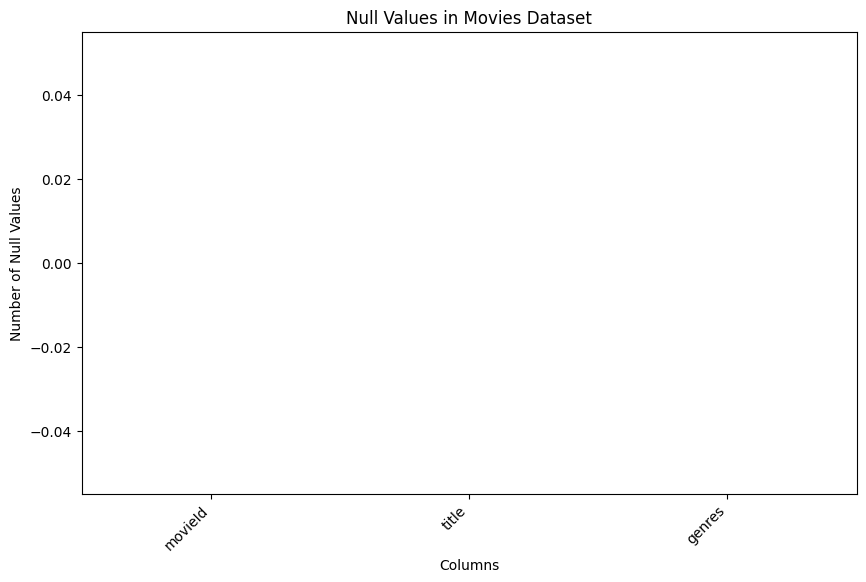

In [27]:
# Assuming moviesdf is your DataFrame
null_values = moviesdf.isna().sum()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=null_values.index, y=null_values.values, palette="viridis")
plt.title("Null Values in Movies Dataset")
plt.xlabel("Columns")
plt.ylabel("Number of Null Values")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.show()

In [28]:
print(f"Total null values in the tags datasets are :\n{tagsdf.isna().sum()}")

Total null values in the tags datasets are :
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64


In [29]:
print(f"Total null values in the links datasets are :\n{linksdf.isna().sum()}")

Total null values in the links datasets are :
movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [31]:
linksdf=linksdf.dropna()

In [32]:
print(f"Total null values in the links datasets are :\n{linksdf.isna().sum()}")

Total null values in the links datasets are :
movieId    0
imdbId     0
tmdbId     0
dtype: int64


In [33]:
print(f"Total null values in the ratings datasets are :\n{ratingsdf.isna().sum()}")

Total null values in the ratings datasets are :
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [34]:
print(f"Total null values in the datasets are :\n{movies_rating_df.isna().sum()}")

Total null values in the datasets are :
movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


In [35]:
# Analysing the insights of the data
movies_rating_df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,19435.295718,326.127564,3.501557,1.205946e+09
std,35530.987199,182.618491,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,1199.000000,177.000000,3.000000,1.019124e+09
50%,2991.000000,325.000000,3.500000,1.186087e+09
75%,8122.000000,477.000000,4.000000,1.435994e+09
max,193609.000000,610.000000,5.000000,1.537799e+09


# EDA

In [36]:
ratingsdf['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [37]:
moviesdf.columns

Index(['movieId', 'title', 'genres'], dtype='object')

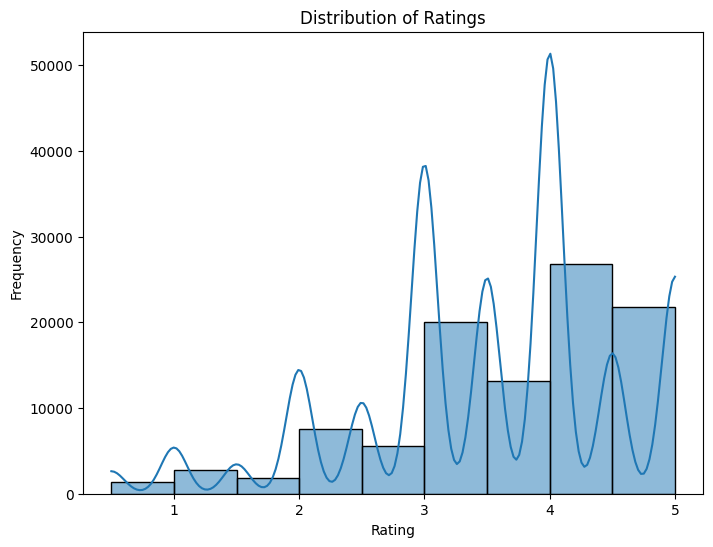

In [38]:
# Data distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(data=ratingsdf, x='rating', bins=9, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [39]:
moviesdf['year']=moviesdf['title'].str.extract(r'\((\d{4})\)')

In [40]:
moviesdf['year'].value_counts().sort_values()

year
1908      1
1903      1
1922      1
1902      1
1921      1
       ... 
2000    283
2007    284
2001    294
2006    295
2002    311
Name: count, Length: 106, dtype: int64

In [41]:
moviesdf.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [42]:
moviesdf['title'] = moviesdf['title'].str.replace(r'\((\d{4})\)', '').str.strip()


In [43]:
def remove_year(title):
    return title[:title.rfind('(')].strip()

# Apply the function to the 'movie_title' column
moviesdf['title'] = moviesdf['title'].apply(remove_year)


In [44]:
moviesdf.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [45]:
moviesdf.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [46]:
moviesdf['year'] = pd.to_numeric(moviesdf['year'], errors='coerce').astype('Int64')


In [47]:
len(moviesdf['year'].unique())

107

In [48]:
moviesdf[moviesdf['year'] > 2005]

,movieId,title,genres,year
5729,27904,"Scanner Darkly, A",Animation|Drama|Mystery|Sci-Fi|Thriller,2006
6086,41863,"Three Burials of Melquiades Estrada, The",Adventure|Crime|Drama,2006
6108,42725,Grandma's Boy,Comedy,2006
6109,42728,Tristan & Isolde,Drama|Romance,2006
6110,42730,Glory Road,Drama,2006
...,...,...,...,...
9736,193579,Jon Stewart Has Left the Building,Documentary,2015
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017
9739,193585,Flint,Drama,2017


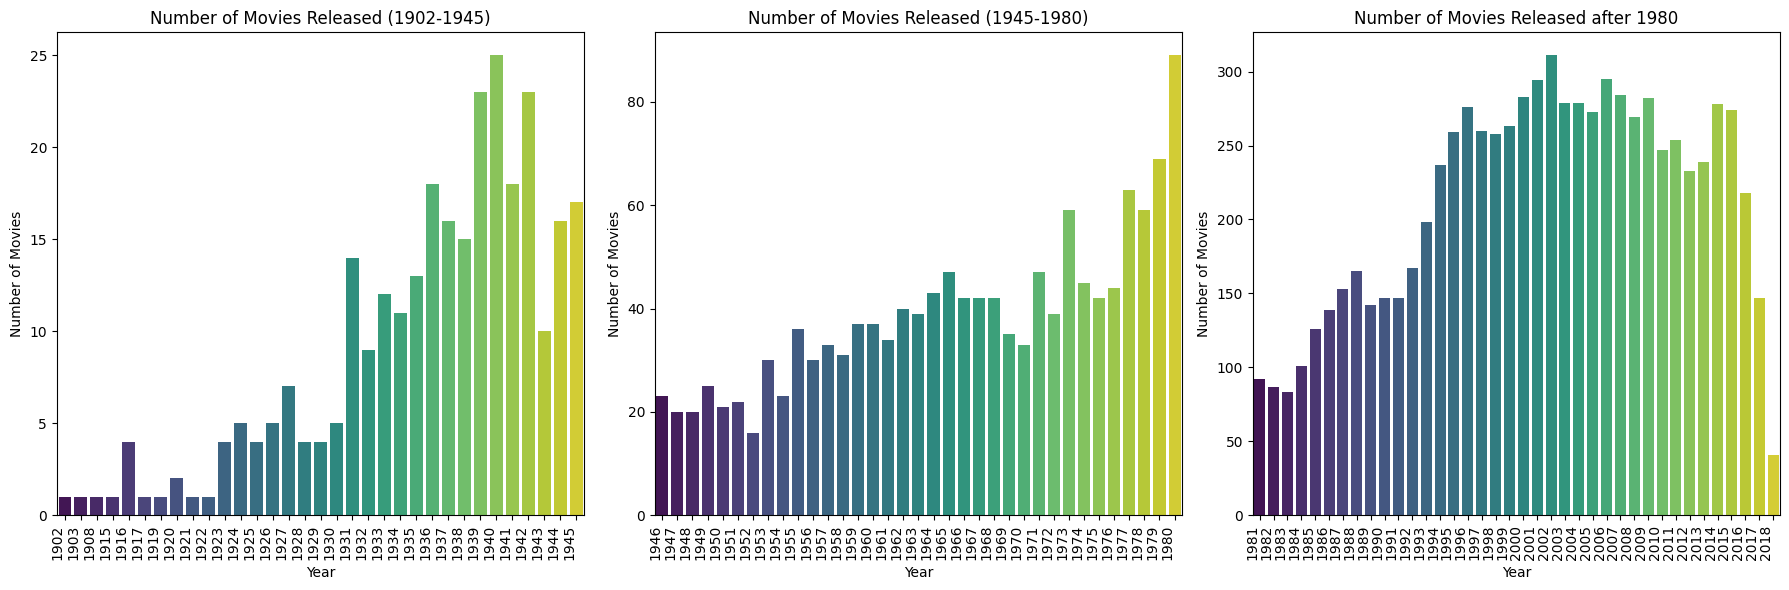

In [51]:
# Filter data for the specified year ranges
movies_1902_1945 = moviesdf[(moviesdf['year'] >= 1902) & (moviesdf['year'] <= 1945)]
movies_1945_1980 = moviesdf[(moviesdf['year'] > 1945) & (moviesdf['year'] <= 1980)]
movies_after_1980=moviesdf[(moviesdf['year'] > 1980)]

# Create separate bar plots for each range
plt.figure(figsize=(18, 6))

# Plot for 1902-1945
plt.subplot(1, 3, 1)
sns.barplot(x=movies_1902_1945['year'].value_counts().index, y=movies_1902_1945['year'].value_counts().values, palette='viridis')
plt.title('Number of Movies Released (1902-1945)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')

# Plot for years from 1945-1980
plt.subplot(1, 3, 2)
sns.barplot(x=movies_1945_1980['year'].value_counts().index, y=movies_1945_1980['year'].value_counts().values, palette='viridis')
plt.title('Number of Movies Released (1945-1980)')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')

# Plot for years from 1980-2018
plt.subplot(1, 3, 3)
sns.barplot(x=movies_after_1980['year'].value_counts().index, y=movies_after_1980['year'].value_counts().values, palette='viridis')
plt.title('Number of Movies Released after 1980')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90, ha='right')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

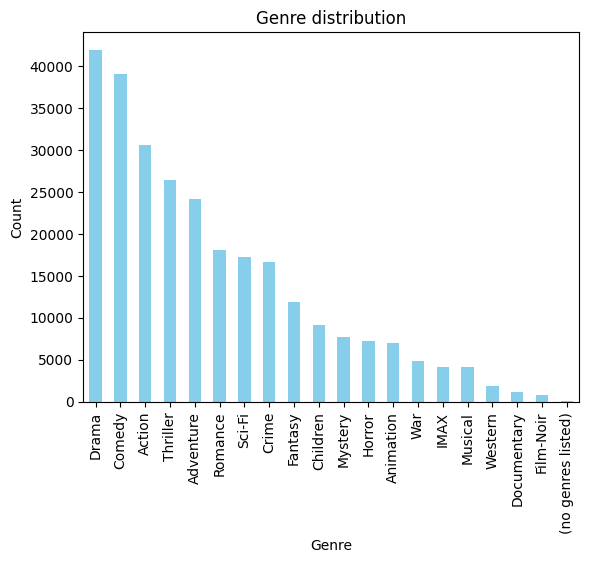

In [52]:
# Genre Analysis
genre_counts=movies_rating_df['genres'].str.split('|', expand=True).stack().value_counts()
genre_counts.plot(kind='bar', color='skyblue')
plt.title("Genre distribution")
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

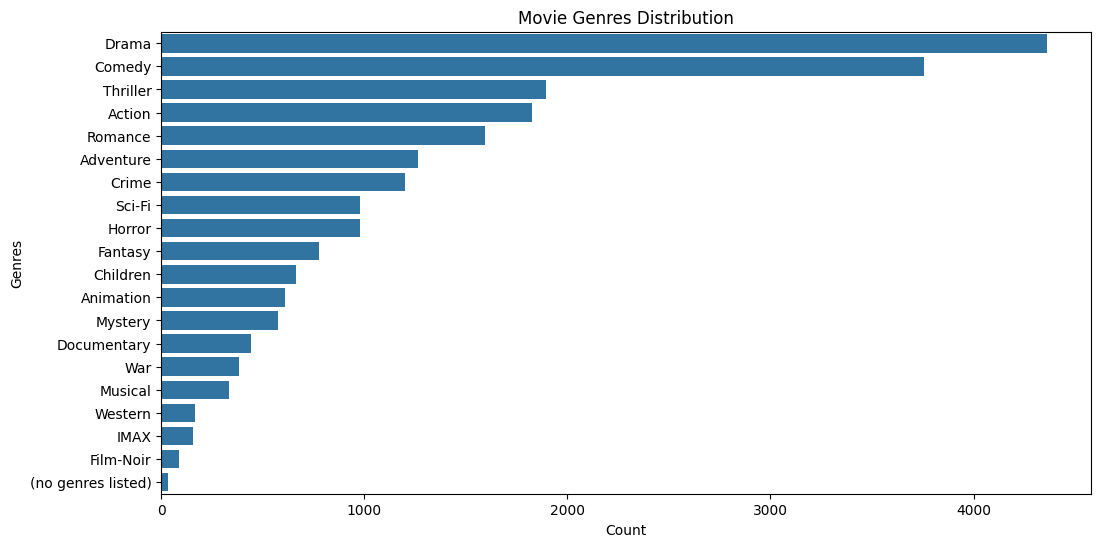

In [53]:
# movie genre distribution
plt.figure(figsize=(12, 6))
genre_counts = moviesdf['genres'].str.split('|').explode().value_counts()
sns.barplot(y=genre_counts.index, x=genre_counts.values, orient='h')
plt.title('Movie Genres Distribution')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.show()

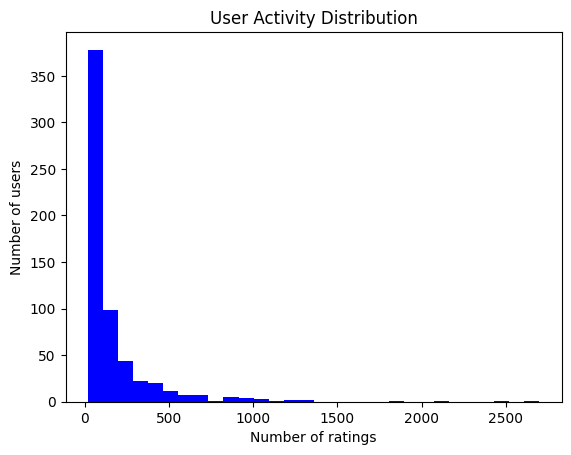

In [54]:
# user activity analysis
# visualising the number of ratings per user
user_activity=movies_rating_df['userId'].value_counts()
user_activity.plot(kind='hist', bins=30, color='blue')
plt.title('User Activity Distribution')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show()

In [55]:
movies_rating_df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [56]:
# tags  distribution
len(tagsdf['tag'].unique())

1589

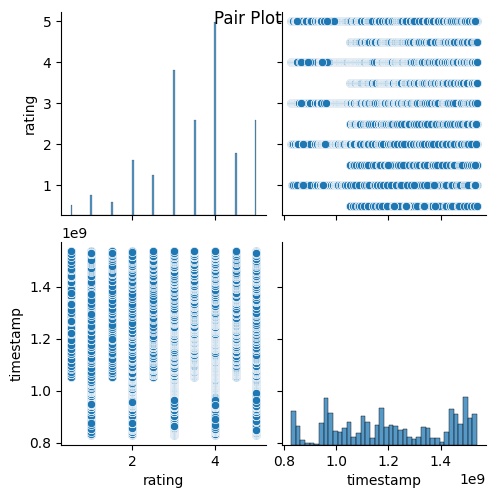

In [57]:
# Ploting pair plot to visualise the realtionship between ratings and timestamp
sns.pairplot(movies_rating_df[['rating', 'timestamp']])
plt.suptitle('Pair Plot')
plt.show()

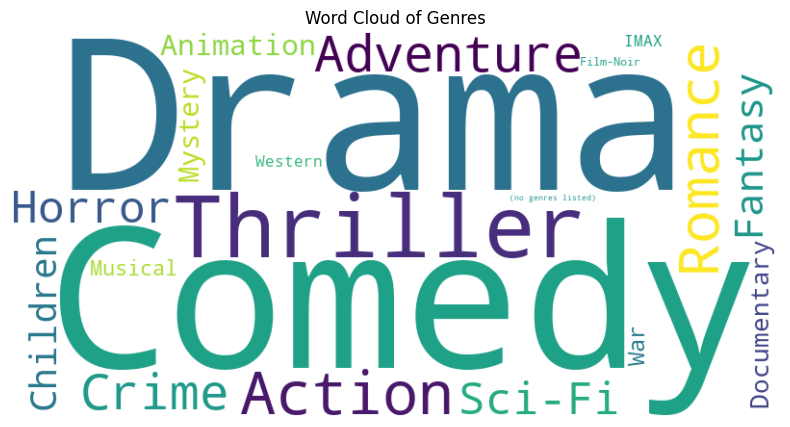

In [58]:
# Assuming 'genres' column contains the genres separated by '|'
genres_list = moviesdf['genres'].str.split('|').explode()

# Count occurrences of each genre
genre_counts = genres_list.value_counts()

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(genre_counts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

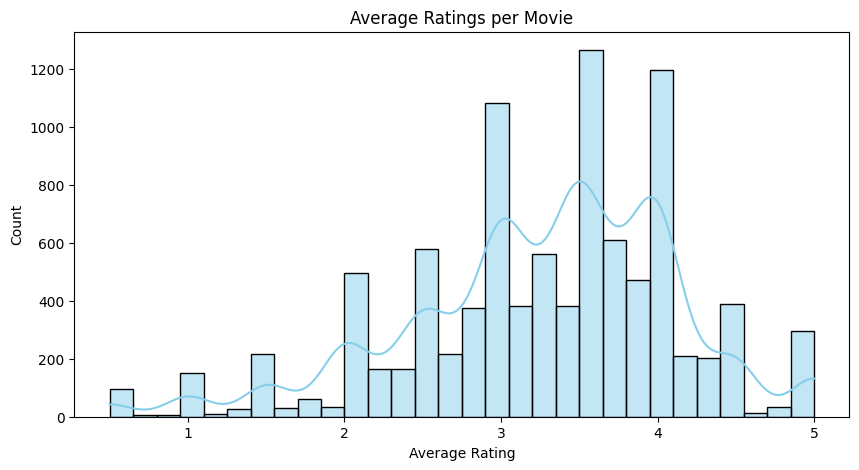

In [60]:
# Visualize the average rating per movie
avg_ratings_per_movie = ratingsdf.groupby('movieId')['rating'].mean()
plt.figure(figsize=(10, 5))
sns.histplot(avg_ratings_per_movie, bins=30, kde=True, color='skyblue')
plt.title('Average Ratings per Movie')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

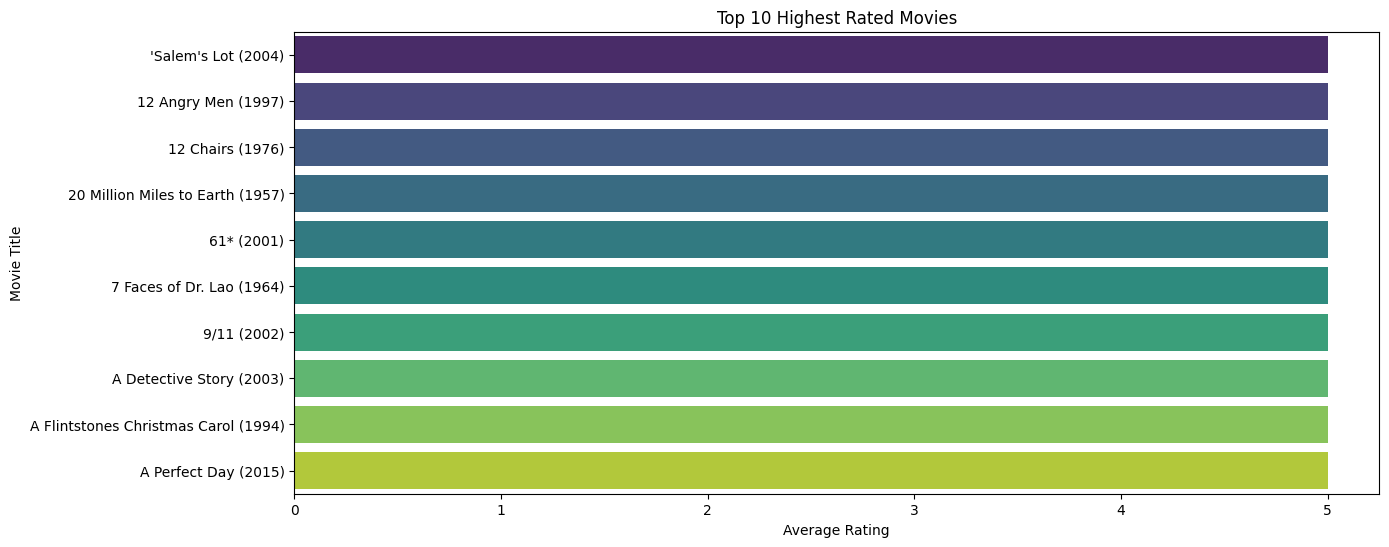

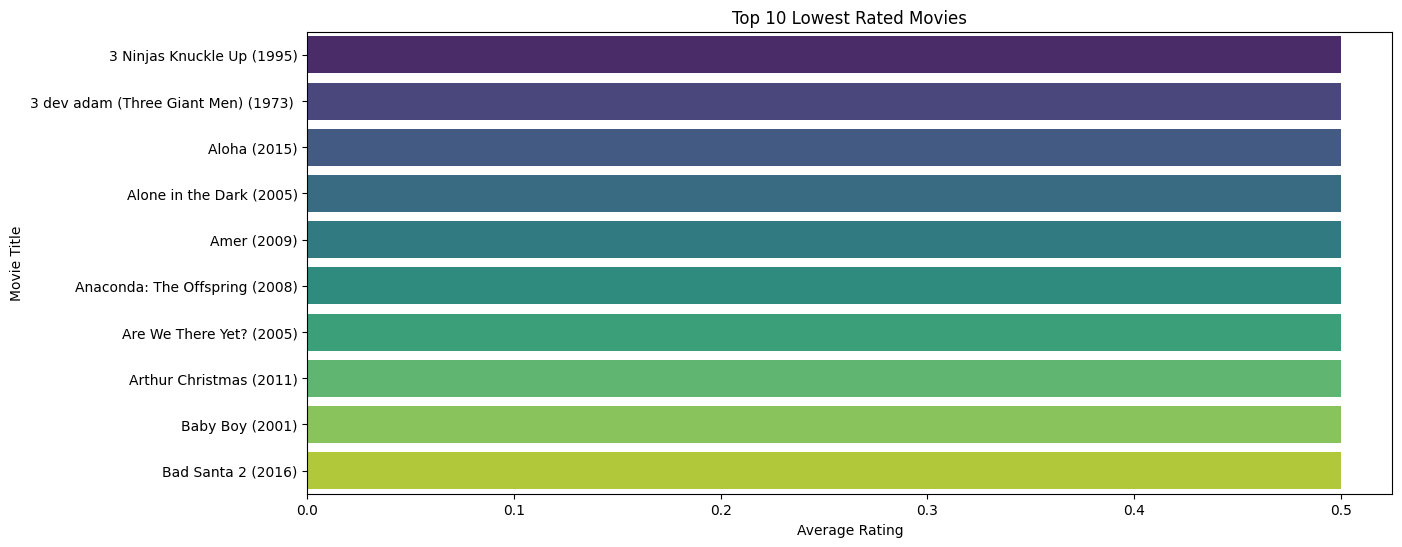

In [61]:
# Calculate average rating per movie
avg_ratings_per_movie = movies_rating_df.groupby('title')['rating'].mean()

# Get the top 10 highest rated movies
top_10_highest_rated = avg_ratings_per_movie.nlargest(10)

# Get the top 10 lowest rated movies
top_10_lowest_rated = avg_ratings_per_movie.nsmallest(10)

# Plot the top 10 highest rated movies
plt.figure(figsize=(14, 6))
sns.barplot(x=top_10_highest_rated.values, y=top_10_highest_rated.index, palette='viridis')
plt.title('Top 10 Highest Rated Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()

# Plot the top 10 lowest rated movies
plt.figure(figsize=(14, 6))
sns.barplot(x=top_10_lowest_rated.values, y=top_10_lowest_rated.index, palette='viridis')
plt.title('Top 10 Lowest Rated Movies')
plt.xlabel('Average Rating')
plt.ylabel('Movie Title')
plt.show()

# Multivariate analysis

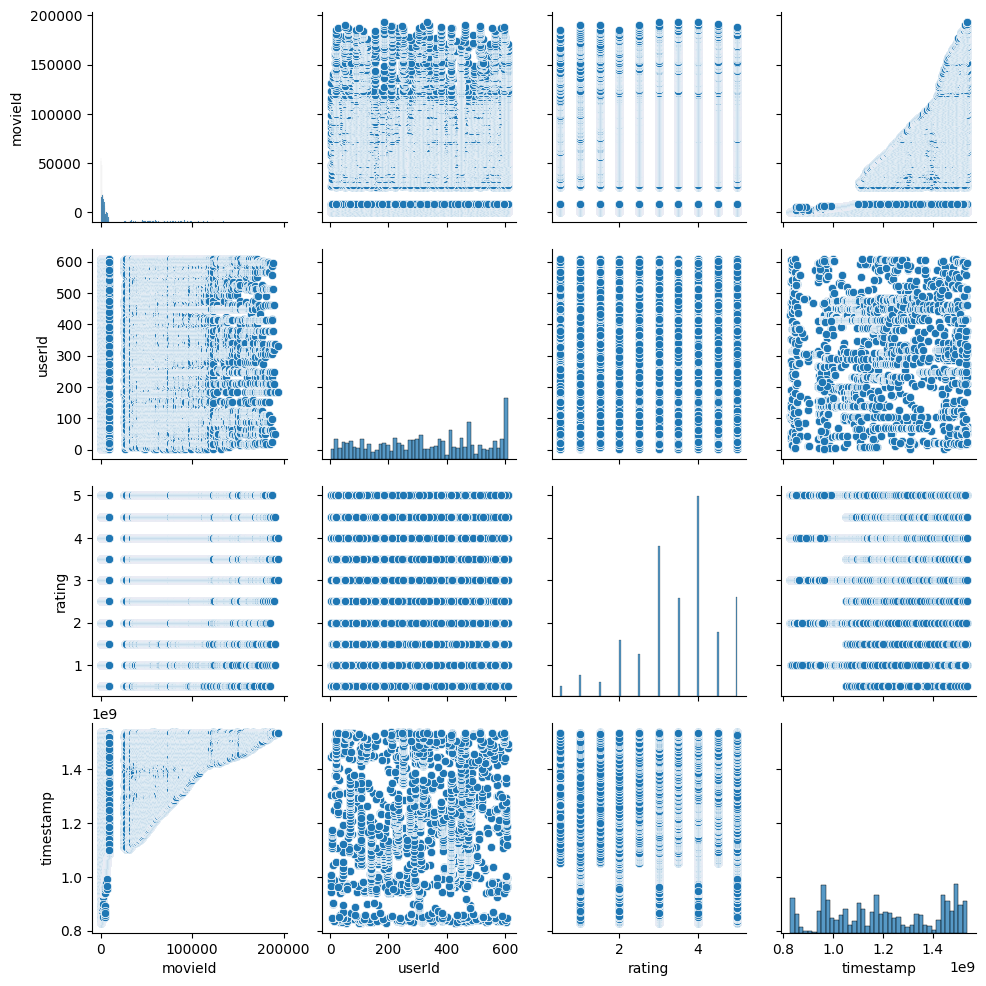

In [62]:
# using the pairplot to do multivariate analysis
sns.pairplot(movies_rating_df)

# Save the figure
plt.savefig('multivariate analysis.png')

# Show the plot
plt.show()

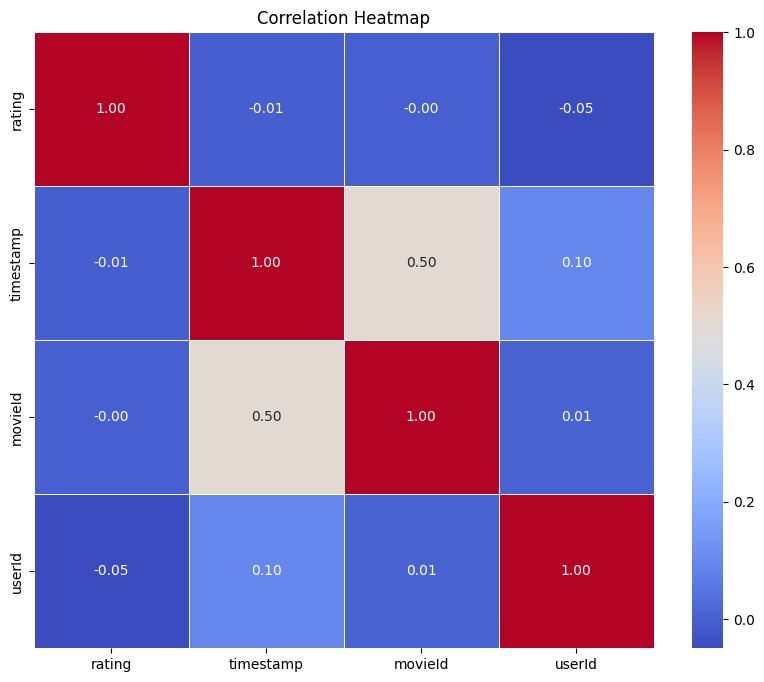

In [63]:
# plotting heatmap
correlation_matrix = movies_rating_df[['rating','timestamp','movieId','userId']].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

In [64]:
movies_rating_df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


# Now creating a content-based recommendation system

# creating a TF-IDF Vectorizer
TF-IDF: Stands for term frequency-inverse document frequency and it a measure, It converts the fraw documents to a matrix of TF-IDF features

In [65]:
movies_rating_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [66]:
tfidf_vectorizer=TfidfVectorizer(stop_words='english')

In [67]:
# fitting the genre in td-idf vectorizer
tfidf_matrix=tfidf_vectorizer.fit_transform(moviesdf['genres'])


In [76]:
moviesdf.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [68]:
tfidf_matrix.shape

(9742, 23)

In [69]:
moviesdf['genres'].value_counts()


genres
Drama                                                  1053
Comedy                                                  946
Comedy|Drama                                            435
Comedy|Romance                                          363
Drama|Romance                                           349
                                                       ... 
Action|Crime|Horror|Mystery|Thriller                      1
Adventure|Animation|Children|Comedy|Musical|Romance       1
Action|Adventure|Animation|Comedy|Crime|Mystery           1
Children|Comedy|Fantasy|Sci-Fi                            1
Action|Animation|Comedy|Fantasy                           1
Name: count, Length: 951, dtype: int64

In [70]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [74]:
# Function for content-based recommendation system
def content_based_recommendation(movie_title, tfidf_matrix, movies_ratings_df):
    try:
        movie_index = movies_ratings_df[movies_ratings_df['title'] == movie_title].index[0]
    except IndexError:
        print(f"Movie with title '{movie_title}' not found in the dataset.")
        return []

    # calculate the cosine similarities between input movies and other movies
    cosine_similarities=cosine_similarity(tfidf_matrix[movie_index], tfidf_matrix).flatten()

    # get the indices of movies most similar to input movie
    similar_movie_indices=cosine_similarities.argsort()[:-11:-1] # getting the top 10 similar movies

    # return the title of the recommended movies
    recommended_movies=movies_ratings_df['title'].iloc[similar_movie_indices].tolist()

    similarity_scores = cosine_similarities[similar_movie_indices].tolist()

    return recommended_movies, similarity_scores



In [77]:
# testing the content-based recommender system
user_input='Toy Story'
recommended_movies,similarity=content_based_recommendation(user_input, tfidf_matrix, moviesdf)
print(f"Recommended movies for {user_input}:")
for movie, score in zip(recommended_movies, similarity):
    print(f"{movie}: Similarity Score = {score}")

Recommended movies for Toy Story:
Toy Story: Similarity Score = 1.0000000000000004
Emperor's New Groove, The: Similarity Score = 1.0000000000000004
Antz: Similarity Score = 1.0000000000000004
Adventures of Rocky and Bullwinkle, The: Similarity Score = 1.0000000000000004
Wild, The: Similarity Score = 1.0000000000000004
Asterix and the Vikings (Astérix et les Vikings): Similarity Score = 1.0000000000000004
Turbo: Similarity Score = 1.0000000000000004
Toy Story 2: Similarity Score = 1.0000000000000004
Shrek the Third: Similarity Score = 1.0000000000000004
Moana: Similarity Score = 1.0000000000000004


In [78]:
moviesdf.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


In [79]:
len(movies_rating_df['title'].value_counts())

9719

# Implementing recommendation system using collaborative filtering using Model-based Collaborative filtering models

In [80]:
ratingsdf.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [81]:
reader=Reader(rating_scale=(1,5))

In [82]:
data=Dataset.load_from_df(ratingsdf[['userId','movieId','rating']], reader)

In [83]:
data.raw_ratings[:5]

[(1, 1, 4.0, None),
 (1, 3, 4.0, None),
 (1, 6, 4.0, None),
 (1, 47, 5.0, None),
 (1, 50, 5.0, None)]

In [84]:
user_ids_in_data = set([uid for uid, _, _, _ in data.raw_ratings])


In [85]:
# splitting the dataset into train and test set
trainset, testset=train_test_split(data, test_size=0.25, random_state=42)

In [86]:
trainset.all_items()

range(0, 8731)

In [87]:
len(testset)

25209

# Implement differnet models with default parameters

In [51]:
# checking other user-based collaborative filtering techniques
models={
    "KNNBasic":KNNBasic(),
    "KNNWithMeans":KNNWithMeans(),
    "KNNWithZScore":KNNWithZScore(),
    "SVD": SVD(),
    "SVDpp": SVDpp(),
    "NMF": NMF(),
    "CoClustering": CoClustering()
}

In [52]:
import time
# function to fit and evaluate the models
def fit_and_evaluate(models,trainset, testset):
    results = pd.DataFrame(columns=['RMSE', 'MSE', 'MAE', 'Train Time (s)', 'Test Time (s)'])
    for name,model in models.items():
#         # Fit the model and measure training time
        start_time = time.time()
        model.fit(trainset)
        train_time = time.time() - start_time

        # Make predictions and measure testing time
        start_time = time.time()
        predictions = model.test(testset)
        test_time = time.time() - start_time

        # evaluate the model
        mse = accuracy.mse(predictions)
        mae= accuracy.mae(predictions)
        rmse = accuracy.rmse(predictions)

        # Add results to the DataFrame
        results.loc[name] = [rmse, mse, mae, train_time, test_time]


        print(f"Evaluating {name}")
        print('Mean Squared Error : ',accuracy.mse(predictions))
        print('Mean Absolute Error : ',accuracy.mse(predictions))
        print('Root Mean Square Error: ',accuracy.rmse(predictions))
        print('Training Time:', train_time, 'seconds')
        print('Testing Time:', test_time, 'seconds')
        print('\n')

    return results

results_df=fit_and_evaluate(models=models, trainset=trainset, testset=testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.9144
MAE:  0.7333
RMSE: 0.9562
Evaluating KNNBasic
MSE: 0.9144
Mean Squared Error :  0.9144084079176346
MSE: 0.9144
Mean Absolute Error :  0.9144084079176346
RMSE: 0.9562
Root Mean Square Error:  0.956247043351055
Training Time: 0.19082975387573242 seconds
Testing Time: 1.7920019626617432 seconds


Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8154
MAE:  0.6896
RMSE: 0.9030
Evaluating KNNWithMeans
MSE: 0.8154
Mean Squared Error :  0.8153780955804212
MSE: 0.8154
Mean Absolute Error :  0.8153780955804212
RMSE: 0.9030
Root Mean Square Error:  0.9029828877561419
Training Time: 0.1406087875366211 seconds
Testing Time: 1.0582945346832275 seconds


Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8112
MAE:  0.6832
RMSE: 0.9007
Evaluating KNNWithZScore
MSE: 0.8112
Mean Squared Error :  0.8111867534509863
MSE: 0.8112
Mean Absolute Error :  0.8111867534

In [68]:
results_df.columns

Index(['RMSE', 'MSE', 'MAE', 'Train Time (s)', 'Test Time (s)'], dtype='object')

In [180]:
results_df=results_df.drop('KNNBaseline')

In [181]:
results_df.index

Index(['KNNBasic', 'KNNWithMeans', 'KNNWithZScore', 'SVD', 'SVDpp', 'NMF',
       'CoClustering'],
      dtype='object')

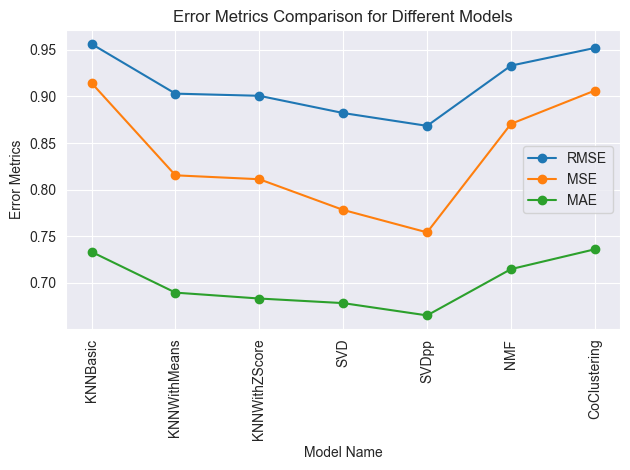

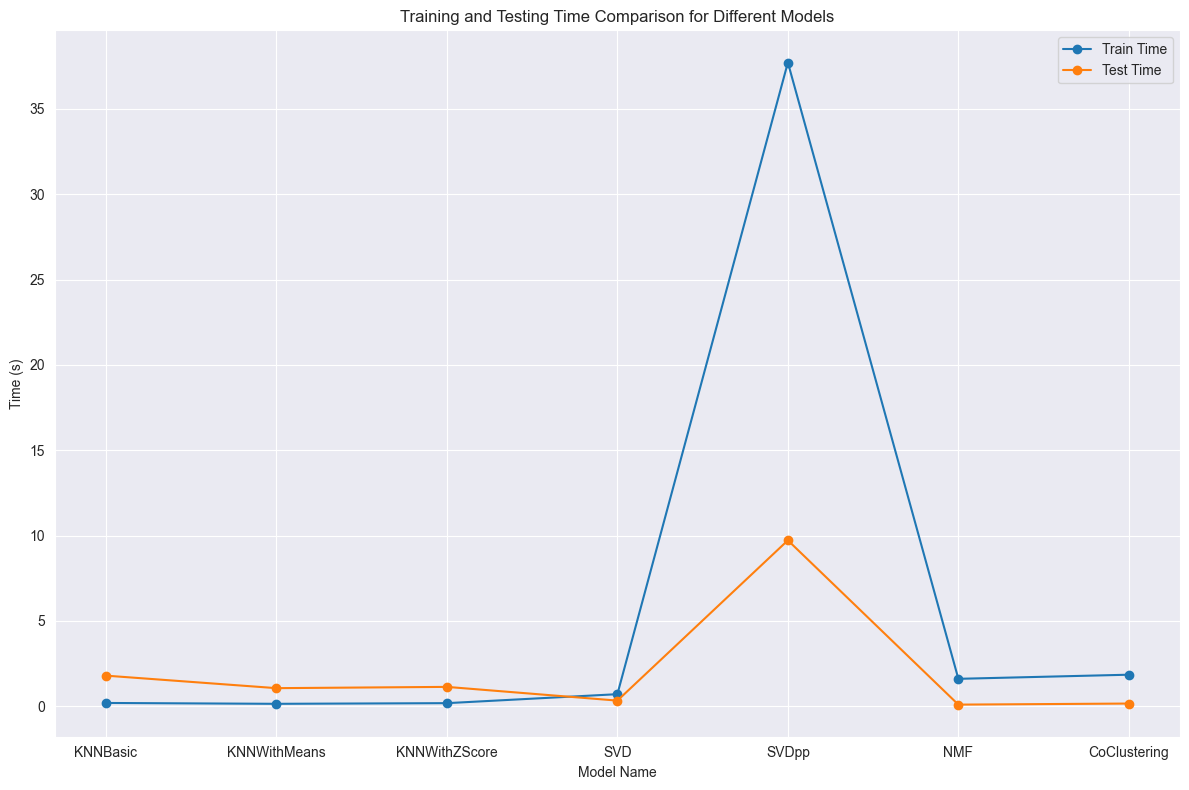

In [182]:

for metric in ['RMSE', 'MSE', 'MAE']:
    plt.plot(results_df.index, results_df[metric], marker='o', label=metric)

plt.xlabel('Model Name')
plt.ylabel('Error Metrics')
plt.title('Error Metrics Comparison for Different Models')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Errormetric.png')
plt.show()


# Plotting Train Time and Test Time
plt.figure(figsize=(12, 8))

plt.plot(results_df.index, results_df['Train Time (s)'], marker='o', label='Train Time')
plt.plot(results_df.index, results_df['Test Time (s)'], marker='o', label='Test Time')

plt.xlabel('Model Name')
plt.ylabel('Time (s)')
plt.title('Training and Testing Time Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('testtraintime.png')
plt.show()


# Hyperparameter tuning

# Hyperparameter tuning for KNNBasic

In [65]:
# Define the parameter grid to search
param_grid = {
    'k': [20, 40, 60],  # Number of neighbors
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson'],  # Similarity metric
        'user_based': [True, False]  # User-based or item-based
    }
}

# Create the KNNBasic model
knn_model = KNNBasic()

# Perform grid search
grid_search = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae', 'mse'], cv=5)
grid_search.fit(data)

# Get the best parameters and the best score
best_params_knnbasic = grid_search.best_params
best_score = grid_search.best_score

# Train the model with the best parameters
best_model = KNNBasic(**best_params_knnbasic)
best_model.fit(trainset)

# Make predictions on the test set
predictions = best_model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
mse=accuracy.mse(predictions)

print(f"Final RMSE on Test Set: {rmse}")
print(f"Final MAE on Test Set: {mae}")
print(f"Final MSE on Test Set: {mse}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9508
MSE: 0.9040
MAE:  0.7251
RMSE: 0.9155
MSE: 0.8381
MAE:  0.6962
RMSE: 0.9133
MSE: 0.8341
MAE:  0.6991
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9503
MSE: 0.9032
MAE:  0.7265
RMSE: 0.9036
MSE: 0.8164
MAE:  0.6861
RMSE: 0.9050
MSE: 0.8190
MAE:  0.6916
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9535
MSE: 0.9091
MAE:  0.7303
RMSE: 0.9013
MSE: 0.8123
MAE:  0.6840
RMSE: 0.9034
MSE: 0.8162
MAE:  0.6902
C

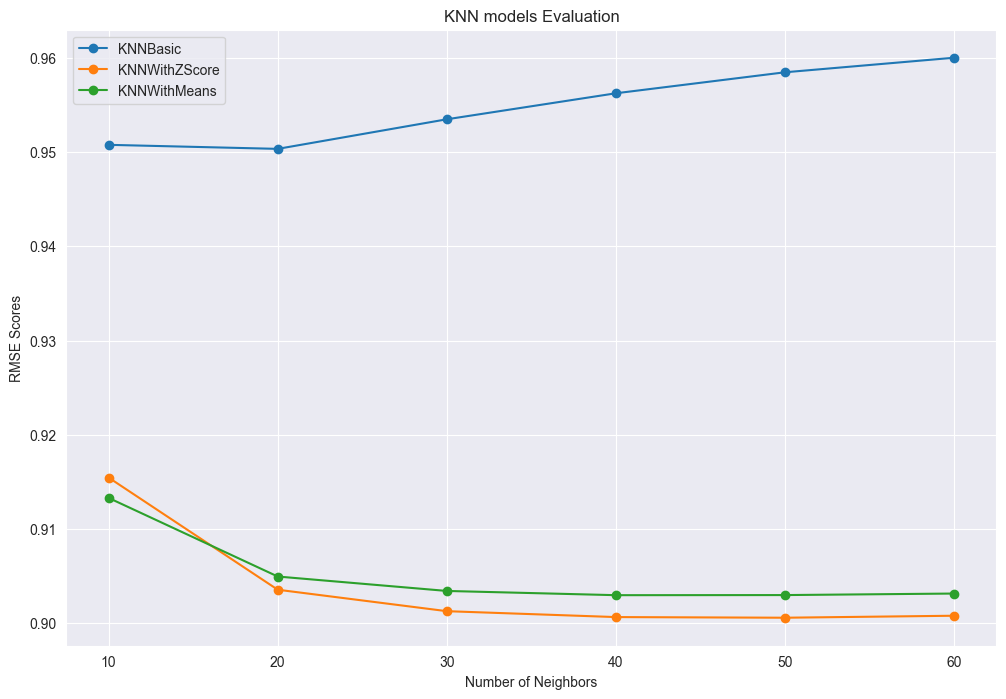

In [177]:
# Define a range of neighbor values to test
neighbor_values = [10,20,30,40,50,60]

# Lists to store evaluation scores for each model
rmse_scores_basic = []
mse_scores_basic = []
mae_scores_basic = []

rmse_scores_zscore = []
mse_scores_zscore = []
mae_scores_zscore = []

rmse_scores_means = []
mse_scores_means = []
mae_scores_means = []

# Iterate over different number of neighbors
for neighbors in neighbor_values:
    # Create the KNN model with the specified number of neighbors
    model_basic = KNNBasic(k=neighbors)
    model_withmean = KNNWithMeans(k=neighbors)
    model_withzscore=KNNWithZScore(k=neighbors)

    # fit the model
    model_basic.fit(trainset)
    model_withmean.fit(trainset)
    model_withzscore.fit(trainset)

    predictions_basic=model_basic.test(testset)
    predictions_mean=model_withmean.test(testset)
    predictions_zscore=model_withzscore.test(testset)

    # Append the mean scores to the lists
    rmse_scores_basic.append(accuracy.rmse(predictions_basic))
    mse_scores_basic.append(accuracy.mse(predictions_basic))
    mae_scores_basic.append(accuracy.mae(predictions_basic))

    rmse_scores_zscore.append(accuracy.rmse(predictions_zscore))
    mse_scores_zscore.append(accuracy.mse(predictions_zscore))
    mae_scores_zscore.append(accuracy.mae(predictions_zscore))

    rmse_scores_means.append(accuracy.rmse(predictions_mean))
    mse_scores_means.append(accuracy.mse(predictions_mean))
    mae_scores_means.append(accuracy.mae(predictions_mean))

# Plotting
plt.figure(figsize=(12, 8))
# RMSE plot
plt.plot(neighbor_values, rmse_scores_basic, marker='o', label='KNNBasic')
plt.plot(neighbor_values, rmse_scores_zscore, marker='o', label='KNNWithZScore')
plt.plot(neighbor_values, rmse_scores_means, marker='o', label='KNNWithMeans')

# Adding labels and title
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE Scores')
plt.title('KNN models Evaluation')
plt.legend()
plt.grid(True)
plt.savefig('KNNEvaluation.png')

# Tuning KNNWithMeans

In [66]:
# Define the parameter grid to search
param_grid = {
    'k': [20, 40, 60],  # Number of neighbors
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson'],  # Similarity metric
        'user_based': [True, False]  # User-based or item-based
    }
}

# Create the KNNBasic model
knn_model = KNNWithMeans()

# Perform grid search
grid_search = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae', 'mse'], cv=5)
grid_search.fit(data)

# Get the best parameters and the best score
best_params_knnmean = grid_search.best_params
best_score = grid_search.best_score


# Train the model with the best parameters
best_model = KNNBasic(**best_params_knnmean)
best_model.fit(trainset)

# Make predictions on the test set
predictions = best_model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
mse=accuracy.mse(predictions)

print(f"Final RMSE on Test Set: {rmse}")
print(f"Final MAE on Test Set: {mae}")
print(f"Final MSE on Test Set: {mse}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

# Tuning KNNWithZScore

In [67]:
# Define the parameter grid to search
param_grid = {
    'k': [20, 40, 60],  # Number of neighbors
    'sim_options': {
        'name': ['cosine', 'msd', 'pearson'],  # Similarity metric
        'user_based': [True, False]  # User-based or item-based
    }
}

# Create the KNNBasic model
knn_model = KNNWithZScore()

# Perform grid search
grid_search = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae', 'mse'], cv=5)
grid_search.fit(data)

# Get the best parameters and the best score
best_params_knnzscore = grid_search.best_params
best_score = grid_search.best_score

# Train the model with the best parameters
best_model = KNNWithZScore(**best_params_knnzscore)
best_model.fit(trainset)

# Make predictions on the test set
predictions = best_model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
mse=accuracy.mse(predictions)

print(f"Final RMSE on Test Set: {rmse}")
print(f"Final MAE on Test Set: {mae}")
print(f"Final MSE on Test Set: {mse}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

# let's tune SVD for best parameter

In [69]:
# Define the parameter grid for grid search
param_grid = {'n_factors': [20,50, 100, 150],
              'n_epochs': [10, 20, 30,50],
              'lr_all': [0.002, 0.005, 0.01,0.10],
              'reg_all': [0.02, 0.1, 0.2,0.3]}



In [70]:
# Initialize SVD
svd = SVD()

# Perform grid search
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MSE','MAE'], cv=5)
grid_search.fit(data)



In [71]:
# Get the best parameters and the best RMSE score, mse and MAE score
best_params_svd = grid_search.best_params
best_rmse = grid_search.best_score['rmse']
best_mse=grid_search.best_score['mse']
best_mae=grid_search.best_score['mae']

print(f"Best Parameters: {best_params_svd}")
print(f"Best RMSE: {best_rmse}")

Best Parameters: {'rmse': {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}, 'mse': {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}, 'mae': {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}}
Best RMSE: 0.8506014573891912


TypeError: __init__() got an unexpected keyword argument 'rmse'

# let's tune SVD++

In [111]:
# Define the parameter grid for grid search
param_grid = {'n_epochs': [10, 20, 30,50],  # Number of iteration
              'lr_all': [0.002, 0.005, 0.01,0.10], # Learning rate for all parameters
              'reg_all': [0.02, 0.1, 0.2,0.3]}  # Regularization term for all parameters

In [ ]:
# Initialize SVD++
svdpp = SVDpp()

# Perform grid search
grid_search = GridSearchCV(SVDpp, param_grid, measures=['RMSE','MSE','MAE'], cv=5)
grid_search.fit(data)

In [ ]:
# Get the best parameters and the best RMSE score
best_params_svdpp = grid_search.best_params
best_rmse = grid_search.best_score['rmse']

print(f"Best Parameters: {best_params_svdpp}")
print(f"Best RMSE: {best_rmse}")

# Train the model with the best parameters
best_model = SVDpp(**best_params_svdpp)
best_model.fit(trainset)

# Make predictions on the test set
predictions = best_model.test(testset)

# Evaluate the model
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)
mse=accuracy.mse(predictions)

print(f"Final RMSE on Test Set: {rmse}")
print(f"Final MAE on Test Set: {mae}")
print(f"Final MAE on Test Set: {mse}")

# Let's tune NMF

In [113]:
# Define the parameter grid
param_grid = {'n_factors': [10, 20, 50],
              'n_epochs': [10, 20, 30],
              'biased': [True, False],
              'reg_pu': [0.06, 0.1, 0.2],
              'reg_qi': [0.06, 0.1, 0.2],
              'random_state': [42]}

# Initialize SVD++
nmf=NMF()

# Perform grid search
grid_search = GridSearchCV(NMF, param_grid, measures=['RMSE','MSE','MAE'], cv=5)
grid_search.fit(data)

# Get the best parameters and the best RMSE score
best_params_nmf = grid_search.best_params
best_rmse = grid_search.best_score['rmse']

print(f"Best Parameters: {best_params_nmf}")
print(f"Best RMSE: {best_rmse}")


Best Parameters: {'rmse': {'n_factors': 10, 'n_epochs': 30, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.2, 'random_state': 42}, 'mse': {'n_factors': 10, 'n_epochs': 30, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.2, 'random_state': 42}, 'mae': {'n_factors': 10, 'n_epochs': 30, 'biased': True, 'reg_pu': 0.1, 'reg_qi': 0.2, 'random_state': 42}}
Best RMSE: 0.8661009859340135


TypeError: __init__() got an unexpected keyword argument 'rmse'

In [114]:
best_params_nmf

{'rmse': {'n_factors': 10,
  'n_epochs': 30,
  'biased': True,
  'reg_pu': 0.1,
  'reg_qi': 0.2,
  'random_state': 42},
 'mse': {'n_factors': 10,
  'n_epochs': 30,
  'biased': True,
  'reg_pu': 0.1,
  'reg_qi': 0.2,
  'random_state': 42},
 'mae': {'n_factors': 10,
  'n_epochs': 30,
  'biased': True,
  'reg_pu': 0.1,
  'reg_qi': 0.2,
  'random_state': 42}}

# Let's  tune CoClustring

In [115]:
# Define the parameter grid
param_grid = {'n_cltr_u': [2, 3, 4, 5],
              'n_cltr_i': [2, 3, 4, 5],
              'n_epochs': [10, 20, 30],
              'random_state': [42]}

# Initialize SVD++
coCluster=CoClustering()

# Perform grid search
grid_search = GridSearchCV(CoClustering, param_grid, measures=['RMSE','MSE','MAE'], cv=5)
grid_search.fit(data)

# Get the best parameters and the best RMSE score
best_params_coclstr = grid_search.best_params['rmse']
best_rmse = grid_search.best_score['rmse']

print(f"Best Parameters: {best_params_coclstr}")
print(f"Best RMSE: {best_rmse}")


Best Parameters: {'n_cltr_u': 5, 'n_cltr_i': 2, 'n_epochs': 30, 'random_state': 42}
Best RMSE: 0.9336437134086222


TypeError: __init__() got an unexpected keyword argument 'n_cltr_u'

In [116]:
best_params_coclstr

{'n_cltr_u': 5, 'n_cltr_i': 2, 'n_epochs': 30, 'random_state': 42}

# Accuracy after hyper-paramenter tuning

In [117]:
# initailizing the model with best parameters
updated_models={
    "KNNBasic":KNNBasic(**best_params_knnbasic),
    "KNNWithMeans":KNNWithMeans(**best_params_knnmean),
    "KNNWithZScore":KNNWithZScore(**best_params_knnzscore),
    "SVD": SVD(n_factors= 150, n_epochs= 50, lr_all=0.01, reg_all= 0.1),
    "SVDpp": SVDpp(n_factors=150, n_epochs=50,lr_all=0.01, reg_all= 0.1),
    "NMF": NMF(n_factors= 10,
  n_epochs= 30,
  biased= True,
  reg_pu = 0.1,
  reg_qi = 0.2,
  random_state = 42),
    "CoClustering": CoClustering(n_cltr_u= 5, n_cltr_i = 2, n_epochs = 30, random_state = 42)
}

In [118]:
evaluate_tuned_model=fit_and_evaluate(models=updated_models, trainset=trainset, testset=testset)





Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.9144
MAE:  0.7333
RMSE: 0.9562
Evaluating KNNBasic
MSE: 0.9144
Mean Squared Error :  0.9144084079176346
MSE: 0.9144
Mean Absolute Error :  0.9144084079176346
RMSE: 0.9562
Root Mean Square Error:  0.956247043351055
Training Time: 0.17278337478637695 seconds
Testing Time: 1.2534875869750977 seconds


Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8154
MAE:  0.6896
RMSE: 0.9030
Evaluating KNNWithMeans
MSE: 0.8154
Mean Squared Error :  0.8153780955804212
MSE: 0.8154
Mean Absolute Error :  0.8153780955804212
RMSE: 0.9030
Root Mean Square Error:  0.9029828877561419
Training Time: 0.24529123306274414 seconds
Testing Time: 1.0428895950317383 seconds


Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8112
MAE:  0.6832
RMSE: 0.9007
Evaluating KNNWithZScore
MSE: 0.8112
Mean Squared Error :  0.8111867534509863
MSE: 0.8112
Mean Absolute Error :  0.811186753

In [185]:
evaluate_tuned_model=evaluate_tuned_model.drop('KNNBaseline')

In [186]:
evaluate_tuned_model

,RMSE,MSE,MAE,Train Time (s),Test Time (s)
KNNBasic,0.956247,0.914408,0.733266,0.172783,1.253488
KNNWithMeans,0.902983,0.815378,0.689559,0.245291,1.042890
KNNWithZScore,0.900659,0.811187,0.683224,0.172745,1.101100
SVD,0.856223,0.733118,0.656497,2.153437,0.109825
SVDpp,0.854547,0.730250,0.654682,639.724040,12.325927
NMF,0.873122,0.762342,0.672366,0.833358,0.097647
CoClustering,0.946520,0.895900,0.732453,2.912920,0.075780


# Testing on larger dataset

In [162]:
reader = Reader(line_format='user item rating timestamp', sep='::')
new_data = Dataset.load_from_file('Movielens 1M dataset/ratings.dat', reader)


In [164]:
from surprise.model_selection import train_test_split
new_trainset, new_testset= train_test_split(new_data, test_size=0.2, random_state=42)

In [155]:
new_testset.shape,new_trainset.shape

((200042, 4), (800167, 4))

In [165]:
# initailizing the model with best parameters for testing
updated_models={
    "KNNBasic":KNNBasic(**best_params_knnbasic),
    "KNNWithMeans":KNNWithMeans(**best_params_knnmean),
    "KNNWithZScore":KNNWithZScore(**best_params_knnzscore),
    "SVD": SVD(n_factors= 150, n_epochs= 50, lr_all=0.01, reg_all= 0.1),
    "SVDpp": SVDpp(n_factors=150, n_epochs=50,lr_all=0.01, reg_all= 0.1),
    "NMF": NMF(n_factors= 10,
  n_epochs= 30,
  biased= True,
  reg_pu = 0.1,
  reg_qi = 0.2,
  random_state = 42),
    "CoClustering": CoClustering(n_cltr_u= 5, n_cltr_i = 2, n_epochs = 30, random_state = 42)
}

In [166]:
evaluate_1m=fit_and_evaluate(updated_models, new_trainset, new_testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8522
MAE:  0.7281
RMSE: 0.9231
Evaluating KNNBasic
MSE: 0.8522
Mean Squared Error :  0.8521613757998476
MSE: 0.8522
Mean Absolute Error :  0.8521613757998476
RMSE: 0.9231
Root Mean Square Error:  0.9231258721322069
Training Time: 30.04434847831726 seconds
Testing Time: 77.84102702140808 seconds


Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8637
MAE:  0.7383
RMSE: 0.9293
Evaluating KNNWithMeans
MSE: 0.8637
Mean Squared Error :  0.8636678086215304
MSE: 0.8637
Mean Absolute Error :  0.8636678086215304
RMSE: 0.9293
Root Mean Square Error:  0.9293372954000773
Training Time: 27.520132064819336 seconds
Testing Time: 79.87796139717102 seconds


Computing the msd similarity matrix...
Done computing similarity matrix.
MSE: 0.8665
MAE:  0.7363
RMSE: 0.9309
Evaluating KNNWithZScore
MSE: 0.8665
Mean Squared Error :  0.866523238597171
MSE: 0.8665
Mean Absolute Error :  0.86652323859717

In [195]:
evaluate_1m=evaluate_1m.drop('KNNBaseline')

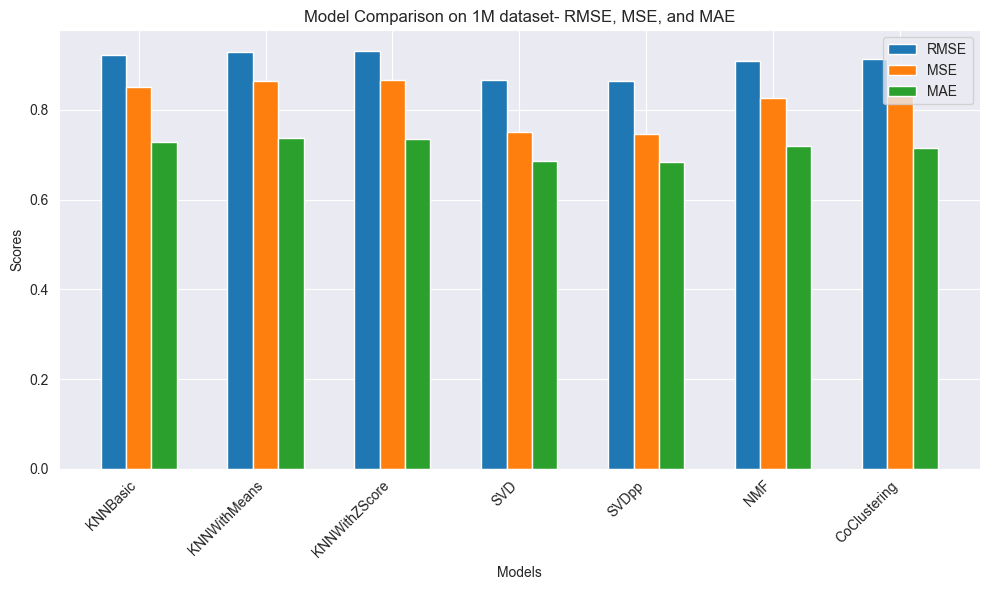

In [196]:
# plotting results_df
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(evaluate_1m.index))

# Plot RMSE scores
ax.bar(bar_positions - bar_width, evaluate_1m['RMSE'], width=bar_width, label='RMSE')
# Plot MSE scores
ax.bar(bar_positions, evaluate_1m['MSE'], width=bar_width, label='MSE')
# Plot MAE scores
ax.bar(bar_positions + bar_width, evaluate_1m['MAE'], width=bar_width, label='MAE')

# Set the x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(evaluate_1m.index, rotation=45, ha='right')

# Set labels and title
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.set_title('Model Comparison on 1M dataset- RMSE, MSE, and MAE')

# Display the legend
ax.legend(loc=1)

# Show the plot
plt.tight_layout()
plt.savefig('comparisionResult1MDataset.png')
plt.show()

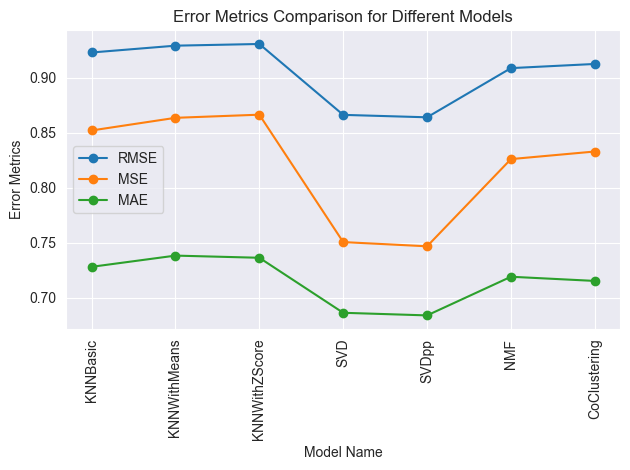

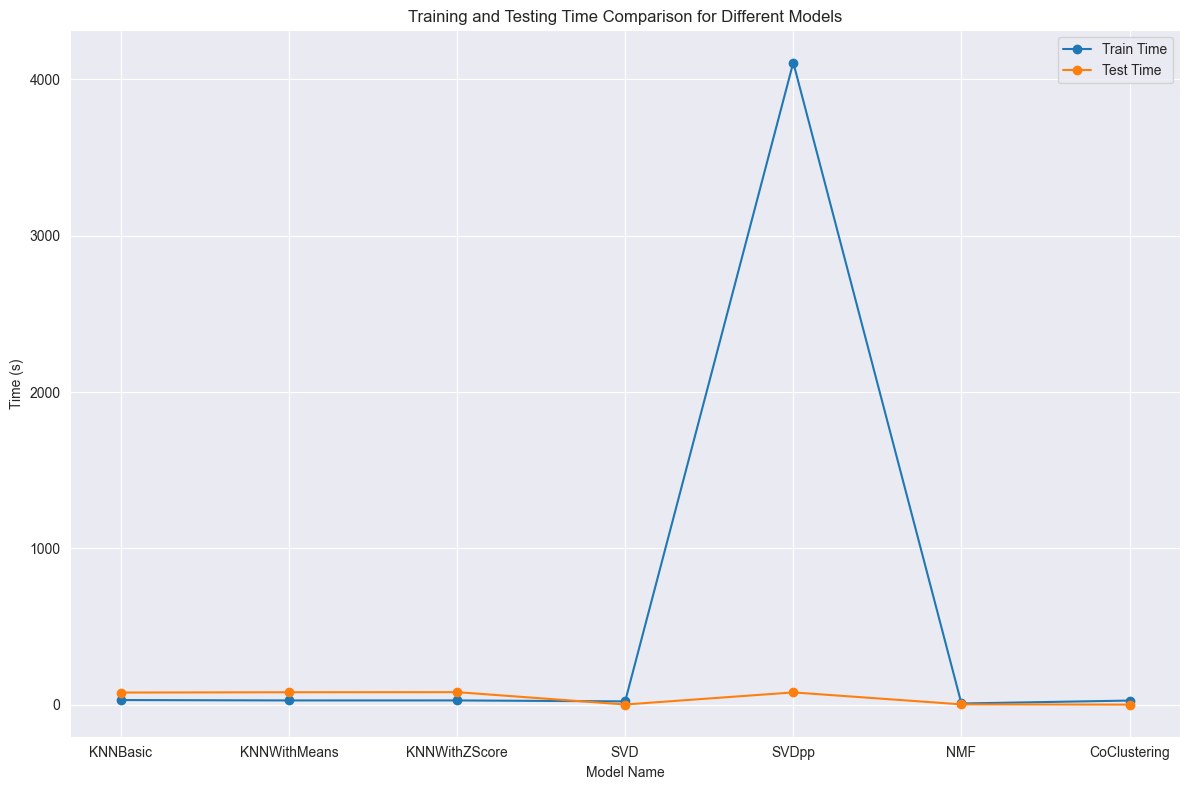

In [197]:

for metric in ['RMSE', 'MSE', 'MAE']:
    plt.plot(evaluate_1m.index, evaluate_1m[metric], marker='o', label=metric)

plt.xlabel('Model Name')
plt.ylabel('Error Metrics')
plt.title('Error Metrics Comparison for Different Models')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Errormetric1m.png')
plt.show()


# Plotting Train Time and Test Time
plt.figure(figsize=(12, 8))

plt.plot(evaluate_1m.index, evaluate_1m['Train Time (s)'], marker='o', label='Train Time')
plt.plot(evaluate_1m.index, evaluate_1m['Test Time (s)'], marker='o', label='Test Time')

plt.xlabel('Model Name')
plt.ylabel('Time (s)')
plt.title('Training and Testing Time Comparison for Different Models')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('testtraintime1m.png')
plt.show()


In [169]:
evaluate_tuned_model.columns

Index(['RMSE', 'MSE', 'MAE', 'Train Time (s)', 'Test Time (s)'], dtype='object')

In [173]:
results_df.dtypes

RMSE              float64
MSE               float64
MAE               float64
Train Time (s)    float64
Test Time (s)     float64
dtype: object

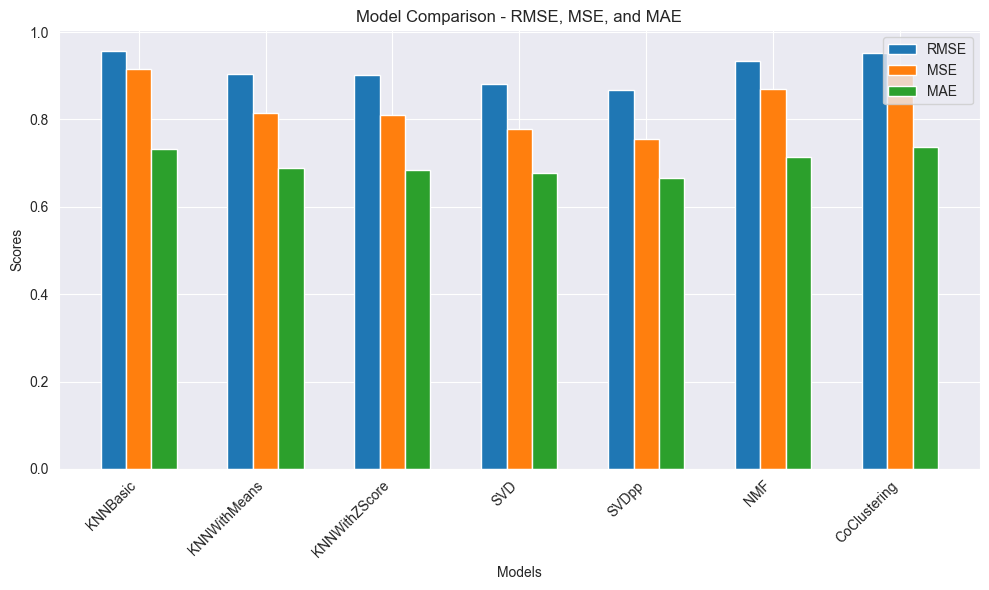

In [189]:
# plotting results_df
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(results_df.index))

# Plot RMSE scores
ax.bar(bar_positions - bar_width, results_df['RMSE'], width=bar_width, label='RMSE')
# Plot MSE scores
ax.bar(bar_positions, results_df['MSE'], width=bar_width, label='MSE')
# Plot MAE scores
ax.bar(bar_positions + bar_width, results_df['MAE'], width=bar_width, label='MAE')

# Set the x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')

# Set labels and title
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.set_title('Model Comparison - RMSE, MSE, and MAE')

# Display the legend
ax.legend(loc=1)

# Show the plot
plt.tight_layout()
plt.savefig('comparisionResult.png')
plt.show()

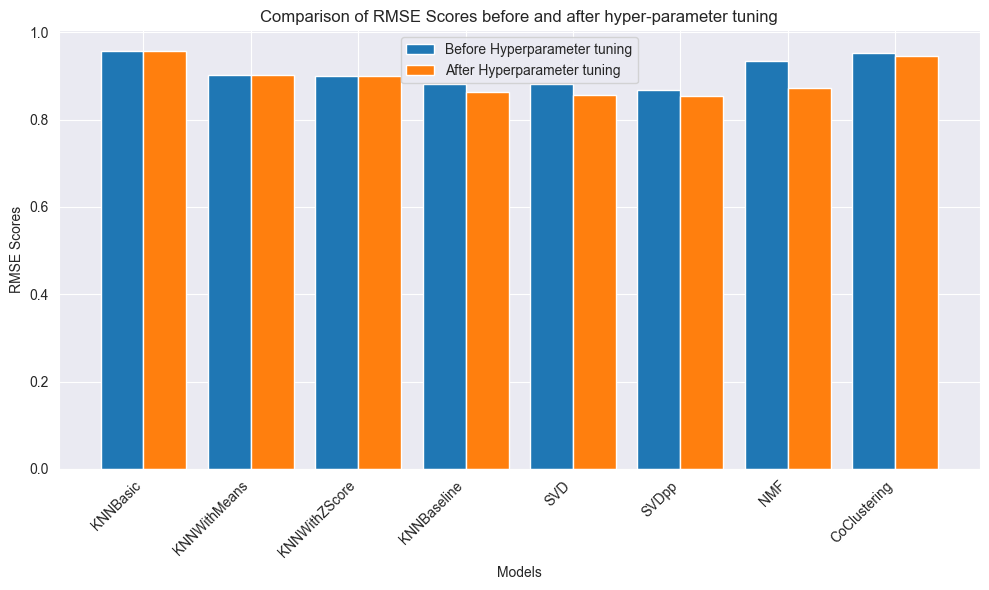

In [176]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.4

# Set the positions for the bars
bar_positions1 = np.arange(len(results_df.index))
bar_positions2 = bar_positions1 + bar_width

# Plot RMSE scores for df1
ax.bar(bar_positions1, results_df['RMSE'], width=bar_width, label='Before Hyperparameter tuning')
# Plot RMSE scores for df2
ax.bar(bar_positions2, evaluate_tuned_model['RMSE'], width=bar_width, label='After Hyperparameter tuning')

# Set the x-axis ticks and labels
ax.set_xticks(bar_positions1 + bar_width / 2)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')

# Set labels and title
ax.set_ylabel('RMSE Scores')
ax.set_xlabel('Models')
ax.set_title('Comparison of RMSE Scores before and after hyper-parameter tuning')

# Display the legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig('beforeandafter.png')
plt.show()

# Comparision of models after hyper parameter tuning

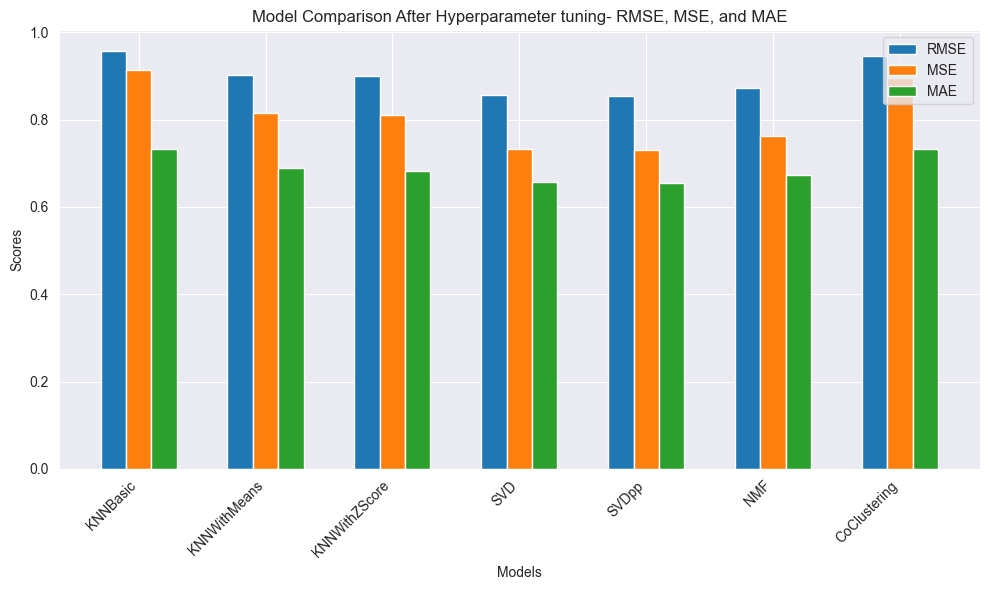

In [191]:
# plotting results_df
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Set the width of the bars
bar_width = 0.2

# Set the positions for the bars
bar_positions = np.arange(len(evaluate_tuned_model.index))

# Plot RMSE scores
ax.bar(bar_positions - bar_width, evaluate_tuned_model['RMSE'], width=bar_width, label='RMSE')
# Plot MSE scores
ax.bar(bar_positions, evaluate_tuned_model['MSE'], width=bar_width, label='MSE')
# Plot MAE scores
ax.bar(bar_positions + bar_width, evaluate_tuned_model['MAE'], width=bar_width, label='MAE')

# Set the x-axis ticks and labels
ax.set_xticks(bar_positions)
ax.set_xticklabels(evaluate_tuned_model.index, rotation=45, ha='right')

# Set labels and title
ax.set_ylabel('Scores')
ax.set_xlabel('Models')
ax.set_title('Model Comparison After Hyperparameter tuning- RMSE, MSE, and MAE')

# Display the legend
ax.legend(loc=1)

# Show the plot
plt.tight_layout()
plt.savefig('comparisionResultHyperparameter.png')
plt.show()

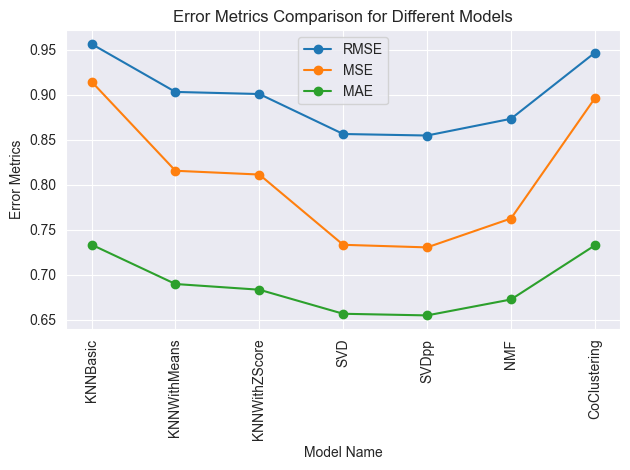

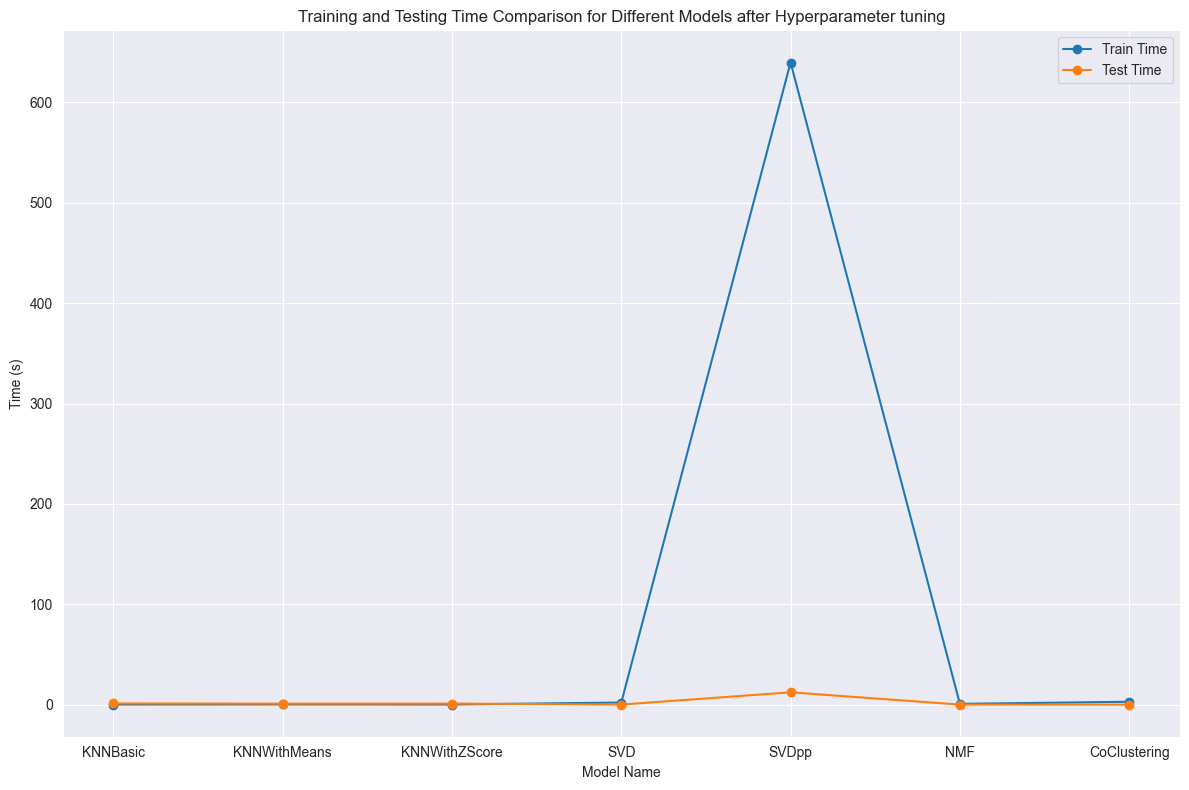

In [193]:

for metric in ['RMSE', 'MSE', 'MAE']:
    plt.plot(evaluate_tuned_model.index, evaluate_tuned_model[metric], marker='o', label=metric)

plt.xlabel('Model Name')
plt.ylabel('Error Metrics')
plt.title('Error Metrics Comparison for Different Models')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ErrormetricHyperparametertuning.png')
plt.show()


# Plotting Train Time and Test Time
plt.figure(figsize=(12, 8))

plt.plot(evaluate_tuned_model.index, evaluate_tuned_model['Train Time (s)'], marker='o', label='Train Time')
plt.plot(evaluate_tuned_model.index, evaluate_tuned_model['Test Time (s)'], marker='o', label='Test Time')

plt.xlabel('Model Name')
plt.ylabel('Time (s)')
plt.title('Training and Testing Time Comparison for Different Models after Hyperparameter tuning')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('testtraintimeHyperParameter.png')
plt.show()


In [208]:
best_params_svd

{'rmse': {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1},
 'mse': {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1},
 'mae': {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}}

# implementing SVD algorithm and evaluating the model

# final testing of SVD and saving the model for future use

In [270]:
# initialize the model
final_svd=SVD(n_factors= 150, n_epochs= 50, lr_all= 0.01, reg_all= 0.1)

In [277]:
# fit the model
final_svd.fit(trainset)
prediction=final_svd.test(testset)
rmse=accuracy.rmse(prediction)
mae=accuracy.mae(prediction)
mse=accuracy.mse(prediction)

RMSE: 0.8578
MAE:  0.6570
MSE: 0.7358


In [273]:
# Saving the model for later use
model_filename='Trained model/final_model_svd.pkl'
with open(model_filename, 'wb') as files:
    pickle.dump(final_svd, files)

# Code to recommend movies using the trained model

In [85]:
# load the saved model
model_filename='Trained model/final_model_svd.pkl'
with open(model_filename, 'rb') as f:
    algo_svd=pickle.load(f)


In [86]:
algo_svd

In [87]:
# mapping the movie id with tmdb id for movie poster
# merge the linksdf with moviesdf
final_moviedf=moviesdf.merge(linksdf, on='movieId')
final_moviedf.head()

,movieId,title,genres,year,imdbId,tmdbId
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,114709,862.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,113497,8844.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,113228,15602.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,114885,31357.0
4,5,Father of the Bride Part II (1995),Comedy,1995,113041,11862.0


In [90]:
def recommend_movies(model,no_movies, user_id,movie_mapping, ratingsdf):
    # Get the list of items rated by the specific user
    all_movies=ratingsdf['movieId'].unique()
    rated_items_by_user=ratingsdf[ratingsdf['userId']==user_id]['movieId'].unique()
    items_not_rated_by_user=list(set(all_movies)-set(rated_items_by_user))
    print('Total movie rated:',len(rated_items_by_user))

    print('Total movies not rated:',len(items_not_rated_by_user))

    # Make predictions for the items not rated by the user
    item_predictions = [model.predict(user_id, item_id) for item_id in items_not_rated_by_user]

    # Sort the predictions by estimated rating
    sorted_predictions = sorted(item_predictions, key=lambda x: x.est, reverse=True)

    # Get the top N recommendations
    top_n_recommendations = sorted_predictions[:no_movies]

    movie_titles=[]
    predicted_ratings=[]
    tmdbIDs=[]

    for recommendation in top_n_recommendations:
        item_id=str(recommendation.iid)
        movie_title=movie_mapping.get(item_id, 'Unknown Movie')
        tmdbID=movie_mapping.get(item_id,'Unknown Movie')
        movie_titles.append(movie_title)
        predicted_ratings.append(recommendation.est)
        tmdbIDs.append(tmdbID)
        print(f"User:{recommendation.uid}  Movie ID:{item_id}  Movie Title: {movie_title}   Predicted rating: {recommendation.est}    TMDBID:{tmdbID}")

    return  movie_titles, predicted_ratings, tmdbIDs

In [93]:
all_items = trainset.all_items()
user_id=1
number_movies=10
movie_mapping = dict(zip(final_moviedf['movieId'].astype(str),final_moviedf['tmdbId']))
movie_title, ratings, tmdbIDs=recommend_movies(model=algo_svd,no_movies= number_movies, user_id=user_id, movie_mapping=movie_mapping, ratingsdf=ratingsdf)

Total movie rated: 232
Total movies not rated: 9492
User:1  Movie ID:750  Movie Title: 935.0   Predicted rating: 5    TMDBID:935.0
User:1  Movie ID:858  Movie Title: 238.0   Predicted rating: 5    TMDBID:238.0
User:1  Movie ID:908  Movie Title: 213.0   Predicted rating: 5    TMDBID:213.0
User:1  Movie ID:1104  Movie Title: 702.0   Predicted rating: 5    TMDBID:702.0
User:1  Movie ID:1172  Movie Title: 11216.0   Predicted rating: 5    TMDBID:11216.0
User:1  Movie ID:1178  Movie Title: 975.0   Predicted rating: 5    TMDBID:975.0
User:1  Movie ID:1193  Movie Title: 510.0   Predicted rating: 5    TMDBID:510.0
User:1  Movie ID:1204  Movie Title: 947.0   Predicted rating: 5    TMDBID:947.0
User:1  Movie ID:1217  Movie Title: 11645.0   Predicted rating: 5    TMDBID:11645.0
User:1  Movie ID:1237  Movie Title: 490.0   Predicted rating: 5    TMDBID:490.0


In [291]:
def recommend_movies(user_id, model, ratingsdf):
    # Get a list of all the movies the user has not rated
    all_movies = ratingsdf['movieId'].unique()
    user_movies = ratingsdf[ratingsdf['userId'] == user_id]['movieId'].unique()
    print('Rated movies',len(user_movies))
    print('rated movies are:', user_movies)

    new_movies = list(set(all_movies) - set(user_movies))

    # Predict the ratings for the new movies
    predictions = [model.predict(user_id, movie_id) for movie_id in new_movies]

    # Sort the predictions by estimated rating
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Get the top 10 recommendations
    top_recommendations = [prediction.iid for prediction in predictions[:10]]

    return top_recommendations

In [292]:
# Assuming 'algo_svd' is your Surprise SVD model and 'ratingsdf' is your DataFrame
user_id_to_recommend = 1  # Replace with the desired user ID
recommendations = recommend_movies(user_id_to_recommend, algo_svd, ratingsdf)

print(f"Top 10 Recommendations for User {user_id_to_recommend}:")
print(recommendations)

Rated movies 232
rated movies are: [   1    3    6   47   50   70  101  110  151  157  163  216  223  231
  235  260  296  316  333  349  356  362  367  423  441  457  480  500
  527  543  552  553  590  592  593  596  608  648  661  673  733  736
  780  804  919  923  940  943  954 1009 1023 1024 1025 1029 1030 1031
 1032 1042 1049 1060 1073 1080 1089 1090 1092 1097 1127 1136 1196 1197
 1198 1206 1208 1210 1213 1214 1219 1220 1222 1224 1226 1240 1256 1258
 1265 1270 1275 1278 1282 1291 1298 1348 1377 1396 1408 1445 1473 1500
 1517 1552 1573 1580 1587 1617 1620 1625 1644 1676 1732 1777 1793 1804
 1805 1920 1927 1954 1967 2000 2005 2012 2018 2028 2033 2046 2048 2054
 2058 2078 2090 2093 2094 2096 2099 2105 2115 2116 2137 2139 2141 2143
 2161 2174 2193 2253 2268 2273 2291 2329 2338 2353 2366 2387 2389 2395
 2406 2414 2427 2450 2459 2470 2478 2492 2502 2528 2529 2542 2571 2580
 2596 2616 2617 2628 2640 2641 2644 2648 2654 2657 2692 2700 2716 2761
 2797 2826 2858 2872 2899 2916 2944 2947 2